<a href="https://colab.research.google.com/github/ykitaguchi77/GravCont_classification_colab/blob/master/Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Assessment**

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import shutil

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set random seem for reproducibility
manualSeed = 1234
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)

torch.torch.backends.cudnn.benchmark = True
torch.torch.backends.cudnn.enabled = True


'''
grav: 甲状腺眼症
cont: コントロール
黒の空白を挿入することにより225px*225pxの画像を生成、EfficientNetを用いて転移学習
－－－－－－－－－－－－－－
データの構造
gravcont.zip ------grav
               |---cont
'''                                     

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')

Random Seed:  1234
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


TIMEOUT: ignored

#**モジュール群**

In [0]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる

"""
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
"""

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.75,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/My Drive/Deep_learning/gravcont_seed_1234'
n_samples = len(data_dir)

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



print(class_names)
k=0
for i in class_names:
    print(class_names[k]+"_train:"+str(len(os.listdir(path='/content/drive/My Drive/Deep_learning/gravcont_seed_1234/train/'+class_names[k]))))
    k+=1
k=0
for i in class_names:
    print(class_names[k]+"_val:"+str(len(os.listdir(path='/content/drive/My Drive/Deep_learning/gravcont_seed_1234/val/'+class_names[k]))))
    k+=1

print("training data set_total："+ str(len(image_datasets['train'])))
print("validating data set_total："+str(len(image_datasets['val'])))



#**ConvNetの調整**

In [0]:
model_ft = models.resnet50(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

In [18]:
# 重みロード
PATH = '/content/drive/My Drive/Deep_learning/GravCont_Resnet50_ImageNet_seed_1234.pth'
model_ft.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#**Calculate Accuracy**

In [19]:
##########Calculate Accuracy#############
#valフォルダ内のファイル名を取得
image_path = glob.glob("/content/drive/My Drive/Deep_learning/gravcont_seed_1234/val/*/*")
random.shuffle(image_path)  #表示順をランダムにする
print('number of images: ' +str(len(image_path)))
#print(image_path) 


#対象のパスからラベルを抜き出して表示
def getlabel(image_path):
      image_name = os.path.basename(image_path)
      label = os.path.basename(os.path.dirname(image_path))
      return(image_name, label)

'''
#変形後の画像を表示
def image_transform(image_path):

    image=Image.open(image_path)

    
    #変形した画像を表示する
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224)])
    image_transformed = transform(image)
    plt.imshow(np.array(image_transformed))
'''

#評価のための画像下処理
def image_transform(image_path):    
    image=Image.open(image_path)
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image_tensor = transform(image)

    #バッチサイズの次元を先頭に追加した4Dテンソルに変換
    image_tensor.unsqueeze_(0)
    #print(image_tensor.size())  # torch.Size([1, 3, 224, 224])
    image_tensor = image_tensor.to(device) #model_ftをGPUに載せる

    return(image_tensor)

#モデルにした処理した画像を投入して予測結果を表示
def image_eval(image_tensor, label):
    output = model_ft(image_tensor)
    #print(output.size())  # torch.Size([1, 1000])
    #print(output)

    #model_pred:クラス名前、prob:確率、pred:クラス番号
    prob, pred = torch.topk(nn.Softmax(dim=1)(output), 1)
    model_pred = class_names[pred]
    
    #甲状腺眼症のprobabilityを計算（classが0なら1から減算、classが1ならそのまま）
    prob = abs(1-float(prob)-float(pred))
 
    return model_pred, prob, pred

 

def showImage(image_path):
    #画像のインポート
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    #画像のリサイズ
    height = img.shape[0]
    width = img.shape[1]
    resized_img = cv2.resize(img, (int(width*300/height), 300))
    cv2_imshow(resized_img)

def calculateAccuracy (TP, TN, FP, FN):
    accuracy = (TP + TN)/ (TP + TN + FP + FN)
    precision  = TP/(FP + TP)
    recall = TP/(TP + FN)
    specificity = TN/(FP + TN)
    f_value = (2*recall*precision)/(recall+precision)
    return(accuracy, precision, recall, specificity, f_value)


#ここからがメイン
TP, FP, TN, FN, TP, FP, TN, FN = [0,0,0,0,0,0,0,0]
image_name_list = []
label_list = []
model_pred_list = []
hum_pred_list = []

model_pred_class = []
model_pred_prob = []


for i in image_path:
      image_name, label = getlabel(i)  #画像の名前とラベルを取得
      image_tensor = image_transform(i)  #予測のための画像下処理
      model_pred, prob, pred = image_eval(image_tensor, label)  #予測結果を出力   
      #print('Image: '+ image_name)
      #print('Label: '+ label)
      #print('Pred: '+ model_pred)
      #showImage(i)  #画像を表示
      #print() #空白行を入れる
      time.sleep(0.1)

      image_name_list.append(image_name)
      label_list.append(label)
      model_pred_list.append(model_pred)

      model_pred_class.append(int(pred))
      model_pred_prob.append(float(prob))

      if label == class_names[0]:
          if model_pred == class_names[0]:
              TP += 1
          else:
              FN += 1
      elif label == class_names[1]:
          if model_pred == class_names[1]:
              TN += 1
          else:
              FP += 1
      

print(TP, FN, TN, FP)

#Accuracyを計算
accuracy, precision, recall, specificity, f_value = calculateAccuracy (TP, TN, FP, FN)
print('Accuracy: ' + str(accuracy))
print('Precision (positive predictive value): ' + str(precision))
print('Recall (sensitivity): ' + str(recall))
print('Specificity: ' + str(specificity))
print('F_value: ' + str(f_value))

print(model_pred_class)
print(model_pred_prob)


number of images: 128
65 0 0 63
Accuracy: 0.5078125
Precision (positive predictive value): 0.5078125
Recall (sensitivity): 1.0
Specificity: 0.0
F_value: 0.6735751295336787
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.4870483875274658, 0.4541851878166199, 0.4979442358016968, 0.4887378215789795, 0.4598246216773987, 0.4902479648590088, 0.46140336990356445, 0.47387003898620605, 0.4933064579963684, 0.49324721097946167, 0.46290719509124756, 0.4716917872428894, 0.49499285221099854, 0.4558514952659607, 0.4611127972602844, 0.49095290899276733, 0.49069011211395264, 0.49365055561065674, 0.4686231017112732, 0.48883551359176636, 0.46123790740966797, 0.4884127974

#**Drawing ROC curve** 

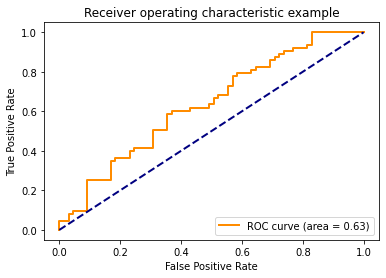

In [14]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score = []
y_true = []

k=0
for i in label_list:
    if label_list[k] == 'cont':
          y_true.append(0)
    elif label_list[k] == 'grav':
          y_true.append(1)
    k+=1


#健康な状態を「0」、病気を「1」としてラベルよりリストを作成
y_true = y_true
#それぞれの画像における陽性の確率についてリストを作成
y_score = model_pred_prob

#print(y_true)
#print(y_score)

fpr, tpr,thred = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

#print(fpr)
#print(tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()